## Milling Tool Wear Maintenance Policy using the REINFORCE algorithm

- Ver. 4.1: 01-May-2023 - Improved plots
- Ver. 4.5: 01-May-2023 - Add Stable-Baselines algo.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces
import gc

from milling_tool_environment import MillingTool_V2
from utilities import plot_learning_curve, single_axes_plot, two_axes_plot, two_variable_plot
from reinforce_classes import PolicyNetwork, Agent

In [2]:
# import importlib
# importlib.reload(utilities)

In [3]:
# Milling operation constants
WEAR_THRESHOLD = 3.0 # mm
WEAR_THRESHOLD_NORMALIZED = 1.0 # normalized to the max wear threshold
MILLING_OPERATIONS_MAX = 400
BREAKDOWN_CHANCE = 0.05

# Policy network learning parameters
gamma = 0.99
alpha = 0.01
EPISODES = 300 # Train for N episodes
PREFIX = 'Tool_Wear_E2_01-May-2023_'

Tool wear data imported (121 records). WEAR_THRESHOLD_NORMALIZED: 0.168


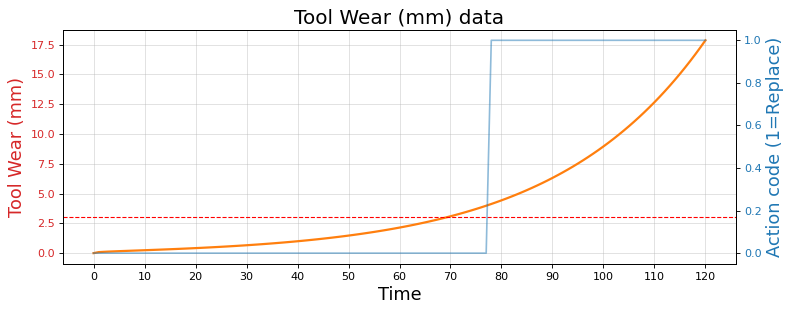

In [4]:
## Read data
df = pd.read_csv('Tool_Wear_VB.csv')
df = df[['time', 'VB_mm', 'ACTION_CODE']]

# Normalizing entire df with min-max scaling
WEAR_MIN = df['VB_mm'].min() 
WEAR_MAX = df['VB_mm'].max()
WEAR_THRESHOLD_NORMALIZED = (WEAR_THRESHOLD-WEAR_MIN)/(WEAR_MAX-WEAR_MIN)
df_normalized = (df-df.min())/(df.max()-df.min())
print(f'Tool wear data imported ({len(df.index)} records). WEAR_THRESHOLD_NORMALIZED: {WEAR_THRESHOLD_NORMALIZED:4.3f}')

## Visualize the data
n_records = len(df.index)
x = df['time'].values.tolist()
y1 = df['VB_mm'].values.tolist()
y2 = df['ACTION_CODE'].values.tolist()

two_axes_plot(x, y1, y2, title='Tool Wear (mm) data', \
              x_label='Time', y1_label='Tool Wear (mm)', y2_label='Action code (1=Replace)', \
              xticks=10,threshold=WEAR_THRESHOLD)

In [5]:
### Main loop
rewards_history = []
loss_history = []

env = MillingTool_V2(df_normalized, WEAR_THRESHOLD_NORMALIZED, MILLING_OPERATIONS_MAX, BREAKDOWN_CHANCE)
# env = MillingTool_V1(df_normalized, WEAR_THRESHOLD_NORMALIZED, MILLING_OPERATIONS_MAX)

input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

agent = Agent(input_dim, output_dim, alpha, gamma)

for episode in range(EPISODES):
    state = env.reset()
    
    # Sample a trajectory
    for t in range(MILLING_OPERATIONS_MAX): # Max. milling operations desired
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        agent.rewards.append(reward)
        #env.render()
        if done:
            break
            
    # Learn during this episode 
    loss = agent.learn() # train per episode
    total_reward = sum(agent.rewards)
    
    # Record statistics for this episode
    rewards_history.append(total_reward)
    loss_history.append(loss.item()) # Extract values from list of torch items for plotting
    
    # On-policy - so discard all data 
    agent.onpolicy_reset()

    if (episode%100 ==0):
        print(f'[{episode:04d}] Loss: {loss:>10.2e} | Reward: {total_reward:>10.2e} | Ep.length: {env.ep_length:04d}')

[0000] Loss:  -2.38e+05 | Reward:  -3.84e+03 | Ep.length: 0400
[0100] Loss:   1.26e+04 | Reward:   1.57e+03 | Ep.length: 0400
[0200] Loss:   9.82e+03 | Reward:   1.13e+03 | Ep.length: 0400


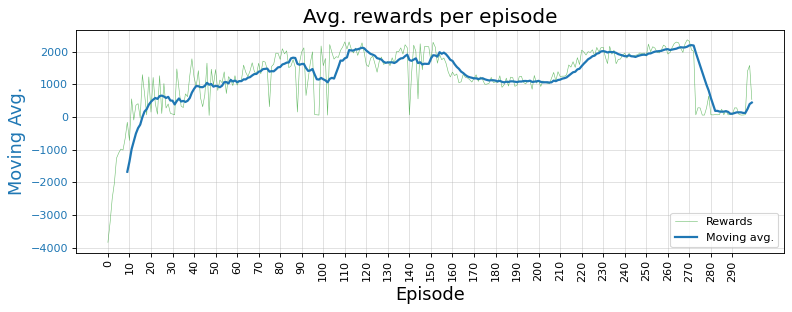

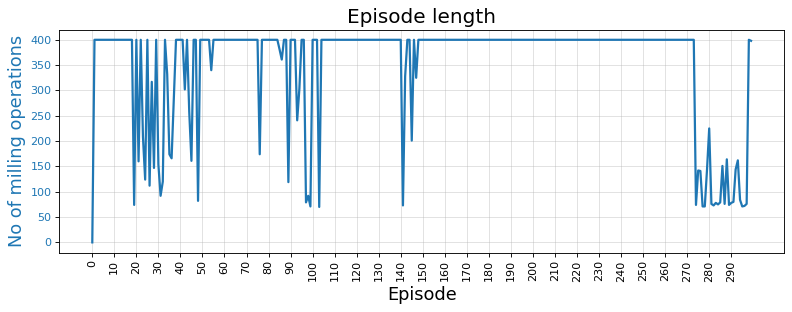

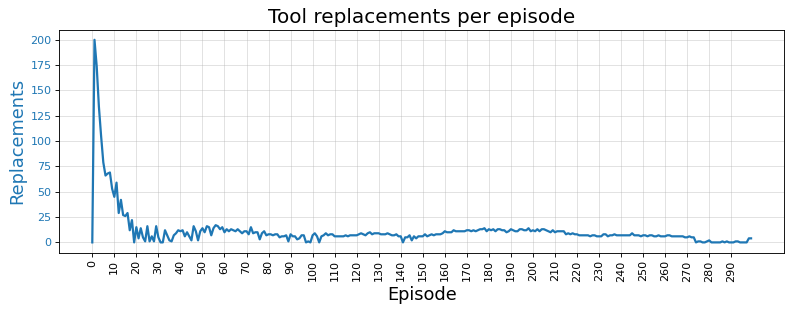

In [6]:
x = [i for i in range(EPISODES)]

#plot_learning_curve(x, rewards_history=rewards_history, loss_history=loss_history, moving_avg_n=10, filename=filename) 

## Moving average for rewards
ma_window_size = 10
# # Convert error array to pandas series
rewards = pd.Series(rewards_history)
windows = rewards.rolling(ma_window_size)
moving_avg = windows.mean()
moving_avg_lst = moving_avg.tolist()
y1 = rewards
y2 = moving_avg_lst

filename = PREFIX + '_Avg_episode_rewards.png'
two_variable_plot(x, y1, y2, 'Avg. rewards per episode', 'Episode', 'Avg. Rewards', 'Moving Avg.', 10, filename)

filename = PREFIX + '_Episode_Length.png'
single_axes_plot(x, env.ep_length_history, 'Episode length', 'Episode', 'No of milling operations', 10, 0.0, filename)

filename = PREFIX + '_Tool_Replacements.png'
single_axes_plot(x, env.ep_tool_replaced_history, 'Tool replacements per episode', 'Episode', 'Replacements', 10, 0.0, filename)

# filename = PREFIX + '_Avg_episode_rewards.png'
# single_axes_plot(x, rewards_history, 'Avg. rewards per episode', 'Episode', 'Avg.Reward', 10, 0.0, filename)

In [7]:
# env.close()

## Stable-Baselines Algorithms

In [9]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO, DQN

In [10]:
EPISODES = 300
PREFIX = 'Tool_Wear_SB-3_01-May-2023_'

In [11]:
env_2 = MillingTool_V2(df_normalized, WEAR_THRESHOLD_NORMALIZED, MILLING_OPERATIONS_MAX, BREAKDOWN_CHANCE)

model_2 = PPO('MlpPolicy', env, verbose=1)
model_2.learn(total_timesteps=EPISODES)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 402       |
|    ep_rew_mean     | -4.02e+03 |
| time/              |           |
|    fps             | 1668      |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 2048      |
----------------------------------


### Test Models

- REINFORCE algorithm: Environment = ```env```, model = ?
- stable_baselines3 algorithm: Environment = ```env_2```, model = ```model_2 ```

In [ ]:
# Create test cases
test_cases = np.random.randint(0, env.df_length-1, 100)
test_cases = np.sort(test_cases)

#### Test-1: REINFORCE algorithm

In [ ]:
cumm_error_0 = 0.0
cumm_error_1 = 0.0
n_0 = 0
n_1 = 0
for idx in test_cases:
    state = env._get_observation(idx)
    action_pred, next_state = model.predict(state)
    action_actual = int(df['ACTION_CODE'][idx])
    e = int(action_pred - action_actual)
    if idx>77:
        cumm_error_0 += abs(e)
        n_0 += 1
        # print(f' ** {idx:4d}: VB (mm): {state[1]*17.855:6.3f} \t Action predicted: {action_pred} \t actual: {action_actual} \t error: {e}')
    else:
        cumm_error_1 += abs(e)
        n_1 += 1
        # print(f'    {idx:4d}: VB (mm): {state[1]*17.855:6.3f} \t Action predicted: {action_pred} \t actual: {action_actual} \t error: {e}')

print(f'\n\n Test-1: REINFORCE algorithm')
print(f' Avg. Error for NORMAL {n_0} cases: {cumm_error_0*100.00/n_0:6.2f} %')
print(f' Avg. Error for REPLACEMENT {n_1} cases: {cumm_error_1*100.00/n_1:6.2f} %')

#### Test-2: Stable-Baselines algorithm

In [ ]:
##
cumm_error_0 = 0.0
cumm_error_1 = 0.0
n_0 = 0
n_1 = 0
for idx in test_cases:
    state = env._get_observation(idx)
    action_pred, next_state = model.predict(state)
    action_actual = int(df['ACTION_CODE'][idx])
    e = int(action_pred - action_actual)
    if idx>77:
        cumm_error_0 += abs(e)
        n_0 += 1
        # print(f' ** {idx:4d}: VB (mm): {state[1]*17.855:6.3f} \t Action predicted: {action_pred} \t actual: {action_actual} \t error: {e}')
    else:
        cumm_error_1 += abs(e)
        n_1 += 1
        # print(f'    {idx:4d}: VB (mm): {state[1]*17.855:6.3f} \t Action predicted: {action_pred} \t actual: {action_actual} \t error: {e}')
        
print(f'\n Avg. Error for NORMAL {n_0} cases: {cumm_error_0*100.00/n_0:6.2f} %')
print(f'\n Avg. Error for REPLACEMENT {n_1} cases: {cumm_error_1*100.00/n_1:6.2f} %')